# Extracting Velocity Based on Contrast Dispersion in Grafts

 - Extract the graft from the peak intensity image on SimVascular:

        Extract .pth of the manual annotation and .vtu of the mesh

 - Register the CT-MPI sequence if needed.
 - Project the Image values onto the mesh.
 - Convert pathline to vtp and project image onto the pathline.
 - Use a gradient filter and argmax to find the point of shuttle mode on the pathline.
 - Clip the lumen at the point where the shuttle mode causes inconsistency.
 - Take a cross-sectional sample every 5 mm along the lumen.
 - Extract the TAC on every point.
 - Detect the upslope. (?)
 - Interpolate each point.
 - Concatenate upper and lower parts of the lumen at the same time points.
 - Extract temporal and spatial gradient.
 - Extract the velocity.
 - Baysian Framework

In [1]:
import vtk
import glob as glob_module
import os
import numpy as np
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
from scipy.stats import linregress
from scipy.integrate import odeint
from scipy.interpolate import CubicSpline, interp1d
import matplotlib.cm as cm
from vtk.util.numpy_support import vtk_to_numpy, numpy_to_vtk
from utilities import *

plt.rcParams['font.family'] = 'Times New Roman'
plt.rcParams['mathtext.fontset'] = 'custom'
plt.rcParams['mathtext.rm'] = 'Times New Roman'

In [2]:
path_ = "/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/3_VesselProjection/VA02B/SVG_RCA"
graft_name = "SVG_RCA"
vtu_file_ = os.path.join(path_,f"{graft_name}.vtu")
centerline_file_ = os.path.join(path_, f"{graft_name}.pth")
Image_directory_ = "/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA02B/CTP"
Image_names = sorted(glob_module.glob(f"{Image_directory_}/*.vtk"))

In [3]:
Image_names

['/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA02B/CTP/VA02B_01.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA02B/CTP/VA02B_02.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA02B/CTP/VA02B_03.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA02B/CTP/VA02B_04.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA02B/CTP/VA02B_05.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA02B/CTP/VA02B_06.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA02B/CTP/VA02B_07.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA02B/CTP/VA02B_08.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA02B/CTP/VA02B_09.vtk',
 '/Users/ana/Documents/AnahitaSeresti/06_ContrastDispersion/1_CTPImages/VA02B/CTP/VA02B_10.vtk']

### Project Images to the Mesh

In [4]:
def ProbeFilter(TargetData, SourceData):
    ProbeFilter=vtk.vtkProbeFilter()
    ProbeFilter.SetInputData(TargetData)
    ProbeFilter.SetSourceData(SourceData)
    ProbeFilter.Update()
    
    return ProbeFilter.GetOutput()

In [5]:
os.path.splitext(os.path.basename(Image_names[0]))[0]

'VA02B_01'

In [6]:
Mesh = ReadVTUFile(vtu_file_)
MeshProjections = {}
for image_name in Image_names:
    Image_ = ReadVTKFile(image_name)
    mesh_projection = ProbeFilter(Mesh, Image_)
    image_root_name = os.path.splitext(os.path.basename(image_name))[0]
    mesh_name = f"{graft_name}_{image_root_name}"
    MeshProjections[image_root_name] = mesh_projection
    WriteVTUFile(os.path.join(path_,f"{mesh_name}.vtu"), mesh_projection)

In [7]:
MeshProjections

{'VA02B_01': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7fed3b2fdaf0) at 0x1a8dbb280>,
 'VA02B_02': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7fed3d0761f0) at 0x1a8dba7a0>,
 'VA02B_03': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7fed3d0789f0) at 0x1a8dba680>,
 'VA02B_04': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7fed3d074950) at 0x1a8dbac80>,
 'VA02B_05': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7fed3d07bcb0) at 0x1a8dba860>,
 'VA02B_06': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7fed3d07e5f0) at 0x1a8dba560>,
 'VA02B_07': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7fed3b78c640) at 0x1a8dbace0>,
 'VA02B_08': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7fed3d075920) at 0x1a8dba620>,
 'VA02B_09': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7fed3d083a00) at 0x1a8dbad40>,
 'VA02B_10': <vtkmodules.vtkCommonDataModel.vtkUnstructuredGrid(0x7fed3d083510) at 0x1a8dba9e0>}

### Read SimVascular Pathline Annotations

In [8]:
with open(centerline_file_, "r") as path:
    #path.readlines()
    tree = ET.parse(path)
root = tree.getroot()

direction_points = []
for direction_point in root.findall(".//path_point/tangent"):
    x = float(direction_point.attrib['x'])
    y = float(direction_point.attrib['y'])
    z = float(direction_point.attrib['z'])
    direction_points.append((x,y,z))

position_points = []
for path_point in root.findall(".//path_point/pos"):
    x = float(path_point.attrib['x'])
    y = float(path_point.attrib['y'])
    z = float(path_point.attrib['z'])
    position_points.append((x,y,z))

path_normals = []
for normal in root.findall(".//path_point/rotation"):
    x = float(normal.attrib['x'])
    y = float(normal.attrib['y'])
    z = float(normal.attrib['z'])
    path_normals.append((x,y,z))

NPoints = len(position_points)
print("the number of points in the centerline is:", NPoints)

binormal = []
for i in range(NPoints):
    binormal_ = np.cross(np.array(direction_points[i]),np.array(path_normals[i]))
    binormal_ /= np.linalg.norm(binormal_)
    binormal.append(binormal_)
    

the number of points in the centerline is: 106


In [35]:
position_points

[(-32.8203125, -199.8828125, -186.5),
 (-33.02586406361689, -199.90081399889894, -186.76683690930972),
 (-33.54634219085068, -199.95244199669682, -187.46051072792912),
 (-34.23748203627601, -200.03413174504524, -188.42076609189365),
 (-34.95501875446757, -200.14231849559576, -189.48734763723883),
 (-35.5546875, -200.2734375, -190.5),
 (-35.929024991064864, -200.42317550880847, -191.34130472552238),
 (-36.11777420032128, -200.58422526816744, -192.0651909963899),
 (-36.19747966404526, -200.7485310231222, -192.76842490449621),
 (-36.24468591851283, -200.90803701871798, -193.54777254173504),
 (-36.3359375, -201.0546875, -194.5),
 (-36.52678597212366, -201.18460896586723, -195.69194418860081),
 (-36.78881100786421, -201.3106569306334, -197.07072528651133),
 (-37.07259930754293, -201.44986916246597, -198.55353429012143),
 (-37.3287375714811, -201.61928342953235, -200.05756219582102),
 (-37.5078125, -201.8359375, -201.5),
 (-37.5732061204405, -202.11026362772262, -202.8189185200744),
 (-37.53

### Interpolation of the pathline

Need to interpolate the pathline to get equi-distance points.

pipeline: 
 - use a cubic spline with a fine resolution. (10000 points).
 - undersample it to get points every 0.5 or 1 mm. Depending on the spacing.

 or:
 - interpolate on x, y, and z separately.

In [37]:
cumulative_distance = [0]
for i in range(1, NPoints):
    dist_ = np.sqrt((position_points[i][0] - position_points[i-1][0])**2 +
                    (position_points[i][1] - position_points[i-1][1])**2 +
                    (position_points[i][2] - position_points[i-1][2])**2 )
    cumulative_distance.append(dist_ + cumulative_distance[i-1])


In [ ]:
# interpolating on x, y, and z separately

spacing = 1 #mm



### Convert Pathline to VTP

In [9]:
def points_to_vtp(points):
    # Create VTK points
    vtk_points = vtk.vtkPoints()
    for point in points:
        vtk_points.InsertNextPoint(point)

    # Create a polyline
    polyline = vtk.vtkPolyLine()
    polyline.GetPointIds().SetNumberOfIds(len(points))
    for i in range(len(points)):
        polyline.GetPointIds().SetId(i, i)

    # Create a cell array to store the polyline
    cells = vtk.vtkCellArray()
    cells.InsertNextCell(polyline)

    # Create a polydata object
    polydata = vtk.vtkPolyData()
    polydata.SetPoints(vtk_points)
    polydata.SetLines(cells)

    return polydata

In [10]:
centerline_vtp = points_to_vtp(position_points)
peak_intensity = 5
image_ = ReadVTKFile(Image_names[peak_intensity])

### split the vessel to the upper and lower segments
splitting into two halves along the z-axis.

In [11]:
def gradient_filter(vtk_image):
    gradient_filter = vtk.vtkImageGradient()
    gradient_filter.SetInputData(vtk_image)
    gradient_filter.SetDimensionality(3)
    gradient_filter.Update()

    return gradient_filter.GetOutput()
    
def define_borders(gradient_image):
    magnitude_filter = vtk.vtkImageMagnitude()
    magnitude_filter.SetInputData(gradient_image)
    magnitude_filter.Update()
    
    return magnitude_filter.GetOutput()

In [12]:
def clip_polydata_with_plane(polydata, origin, normal, inside_out=False):
    plane = vtk.vtkPlane()
    plane.SetOrigin(origin)
    plane.SetNormal(normal)

    clipper = vtk.vtkClipPolyData()
    clipper.SetInputData(polydata)
    clipper.SetClipFunction(plane)

    if inside_out:
        clipper.InsideOutOn()
    else:
        clipper.InsideOutOff()
    
    clipper.Update()

    return clipper.GetOutput()

def clip_USGrid_w_plane(USGrid, origin, normal, inside_out = False):
    plane = vtk.vtkPlane()
    plane.SetOrigin(origin)
    plane.SetNormal(normal)

    clipper = vtk.vtkClipDataSet()
    clipper.SetInputData(USGrid)
    clipper.SetClipFunction(plane)

    if inside_out:
        clipper.InsideOutOn()
    else:
        clipper.InsideOutOff()
    
    clipper.Update()

    return clipper.GetOutput()

In [13]:
x_min = image_.GetBounds()[0]
x_max = image_.GetBounds()[1]

y_min = image_.GetBounds()[2]
y_max = image_.GetBounds()[3]

z_min = image_.GetBounds()[4]
z_max = image_.GetBounds()[5]

center_point = [
    (x_max + x_min)/2,
    (y_max + y_min)/2,
    (z_max + z_min)/2
]
z_axis = [0,0,1]

In [16]:
UpperMesh = {}
LowerMesh = {}

for key, mesh in MeshProjections.items():
    upper_mesh = clip_USGrid_w_plane(mesh, center_point, z_axis, True)
    mesh_name_upper = f"{graft_name}_{key}_upper"
    if upper_mesh.GetNumberOfPoints() == 0:
        UpperMesh[key] = upper_mesh
        WriteVTUFile(os.path.join(path_,f"{mesh_name_upper}.vtu"), upper_mesh)
    
    lower_mesh = clip_USGrid_w_plane(mesh, center_point, z_axis)
    mesh_name_lower = f"{graft_name}_{key}_lower"
    if lower_mesh.GetNumberOfPoints() == 0:
        LowerMesh[key] = lower_mesh
        WriteVTUFile(os.path.join(path_,f"{mesh_name_lower}.vtu"), lower_mesh)


centerline_upper = clip_polydata_with_plane(centerline_vtp, center_point, z_axis, True)
centerline_lower = clip_polydata_with_plane(centerline_vtp, center_point, z_axis)

### Cutting the Lumen Every 3 mm

In [18]:
remainder  = np.array([int(i)%3 for i in cumulative_distance])
indeces = np.where(remainder == 0)
indeces = list(indeces[0])
print(indeces)
indeces_ = [indeces[i] - indeces[i-1] for i in range(1, len(indeces))]
print(indeces_)
indeces_1 = [0]
indeces_1.extend(indeces_)
indeces_1 = indeces_1

indeces_2 = [indeces[i] for i in range(len(indeces_1)) if indeces_1[i] != 1]
print(indeces_2)

[0, 1, 4, 7, 10, 17, 19, 24, 27, 30, 32, 34, 36, 39, 42, 46, 48, 50, 52, 54, 57, 61, 64, 67, 70, 71, 75, 82, 84, 89, 92, 95, 97, 99, 102]
[1, 3, 3, 3, 7, 2, 5, 3, 3, 2, 2, 2, 3, 3, 4, 2, 2, 2, 2, 3, 4, 3, 3, 3, 1, 4, 7, 2, 5, 3, 3, 2, 2, 3]
[0, 4, 7, 10, 17, 19, 24, 27, 30, 32, 34, 36, 39, 42, 46, 48, 50, 52, 54, 57, 61, 64, 67, 70, 75, 82, 84, 89, 92, 95, 97, 99, 102]


In [20]:
def SequentialCut(PointsArray, interval=3):
    """Finds the location of the cut along the centerline of the lumen.

    Args:
        PointsArray (list): a list of the position of the points along the centerline of the vessel.
        interval (int, optional): To perform the clipping. Distance between the cross sections. Defaults to 3.
    """
    NPoints = len(PointsArray)
    cumulative_distance = [0]
    for i in range(1, NPoints):
        dist_ = np.sqrt((PointsArray[i][0] - PointsArray[i-1][0])**2 +
                        (PointsArray[i][1] - PointsArray[i-1][1])**2 +
                        (PointsArray[i][2] - PointsArray[i-1][2])**2 )
        cumulative_distance.append(dist_ + cumulative_distance[i-1])

    remainder  = np.array([int(i)%interval for i in cumulative_distance])
    indeces = np.where(remainder == 0)
    indeces = list(indeces[0])
    indeces_ = [indeces[i] - indeces[i-1] for i in range(1, len(indeces))]
    indeces_1 = [0]
    indeces_1.extend(indeces_)
    indeces_1 = indeces_1

    indeces_2 = [indeces[i] for i in range(len(indeces_1)) if indeces_1[i] != 1]
    #indeces_2[0] = 2

    return indeces_2    

In [21]:
def slice_w_plane(Volume,Origin,Norm):
    plane=vtk.vtkPlane()
    plane.SetOrigin(Origin)
    plane.SetNormal(Norm)
    Slice=vtk.vtkCutter()
    Slice.GenerateTrianglesOff()
    Slice.SetCutFunction(plane)
    Slice.SetInputData(Volume)
    Slice.Update()
    return Slice.GetOutput()

In [22]:
def SphereClip(volume_image,center,radius):
    sphere = vtk.vtkSphere()
    sphere.SetCenter(center)
    sphere.SetRadius(radius)

    clipper = vtk.vtkClipDataSet()
    clipper.SetInputData(volume_image)
    clipper.SetClipFunction(sphere)
    clipper.InsideOutOn()
    clipper.GetOutputInformation(1)
    clipper.Update()

    return clipper.GetOutput()

In [23]:
def GetSurfaceArea(polydata):
    properties = vtk.vtkMassProperties()
    properties.AddInputData(polydata)
    properties.Update()
    return properties.GetSurfaceArea()

In [28]:
CrossSections = vtk.vtkAppendPolyData()
Area_ = [] 
for idx in range(len(position_points)):
    cross_section_ = slice_w_plane(MeshProjections['VA02B_06'], position_points[idx], direction_points[idx])
    area_ = GetSurfaceArea(cross_section_)
    Area_.append(area_)
    radius = np.sqrt(area_/np.pi)
    inner_section_ = SphereClip(cross_section_, GetCentroid(cross_section_), radius*0.75)
    CrossSections.AddInputData(ExtractSurface(inner_section_))
CrossSections.Update()
Area = np.mean(np.array(Area_))
WriteVTPFile(os.path.join(path_, "CrossSections.vtp"), CrossSections.GetOutput())

### Extracting cross sections from upper and lower parts of the lumen

#### Detecting which half is leading

In [29]:
ScalarArrayName = image_.GetPointData().GetArrayName(0)
print(ScalarArrayName)

scalars


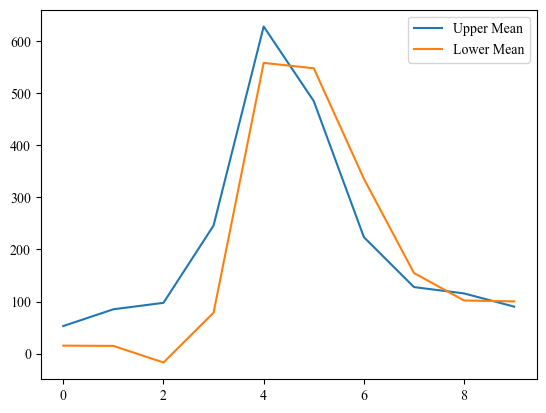

The upper half lags the lower half.


In [31]:
leading = False #if True upper half is leading
upper_mean_ = []
lower_mean_ = []
for name in Image_names:
    Image_ = ReadVTKFile(name)
    centerline_ = ProbeFilter(centerline_vtp, Image_)
    WriteVTPFile(os.path.join(path_, "test_centerline.vtp"), centerline_)
    centerline_upper_ = clip_polydata_with_plane(centerline_, center_point, z_axis, True)
    WriteVTPFile(os.path.join(path_, "test_centerline_upper.vtp"), centerline_upper_)
    centerline_lower_ = clip_polydata_with_plane(centerline_, center_point, z_axis)
    WriteVTPFile(os.path.join(path_, "test_centerline_lower.vtp"), centerline_lower_)
    for i in range(Image_.GetPointData().GetNumberOfArrays()):
        arrayname_ = Image_.GetPointData().GetArrayName(i)
        if "scalar" in arrayname_.lower():
            ScalarArrayName = arrayname_
    upper_mean_.append(np.mean(vtk_to_numpy(centerline_upper_.GetPointData().GetArray(ScalarArrayName))))
    lower_mean_.append(np.mean(vtk_to_numpy(centerline_lower_.GetPointData().GetArray(ScalarArrayName))))

count = [i for i in range(len(Image_names))]
plt.figure()
plt.plot(count, upper_mean_, label = "Upper Mean")
plt.plot(count, lower_mean_, label = "Lower Mean")
plt.legend()
plt.show()

max_lower_idx = np.where(np.array(lower_mean_) == max(lower_mean_))
max_upper_idx = np.where(np.array(upper_mean_) == max(upper_mean_))
if max_lower_idx > max_upper_idx:
    leading = True
    print("The upper half leads the lower half.")
else:
    leading = False
    print("The upper half lags the lower half.")



#### Extract the cross sections along the upper part of the lumen

In [32]:
def GetPoints(polydata):
    """Converts the polydata into a list of points.
    """
    NPoints = polydata.GetNumberOfPoints()
    points = []
    for i in range(NPoints):
        points.append(polydata.GetPoint(i))

    return points

todo: 

~~add another loop that loops over the Upper/Lower meshes.~~

~~create an array of means of each cross section over time.~~

~~interpolate the array (piecewise interpolation).~~

~~remove the first and last elements of each array based on upper half leading or lagging.~~

~~concatenate the arrays.~~

The following two cells are for test purposes only.

In [34]:
centerline_upper_points = GetPoints(centerline_upper)
indeces_u = SequentialCut(centerline_upper_points, 2)
CrossSections_u = vtk.vtkAppendPolyData()
for idx in range(len(centerline_upper_points)):
    cross_section_ = slice_w_plane(UpperMesh[list(UpperMesh.keys())[peak_intensity]], position_points[idx], direction_points[idx])
    radius = np.sqrt(GetSurfaceArea(cross_section_)/np.pi)
    inner_section_ = SphereClip(cross_section_, GetCentroid(cross_section_), radius*0.75)
    CrossSections_u.AddInputData(ExtractSurface(inner_section_))
CrossSections_u.Update()
WriteVTPFile(os.path.join(path_, "CrossSections_Upper.vtp"), CrossSections_u.GetOutput())

IndexError: list index out of range

In [ ]:
centerline_lower_points = GetPoints(centerline_lower)
indeces_l = SequentialCut(centerline_lower_points, 2)
CrossSections_l = vtk.vtkAppendPolyData()
for idx in indeces_l:
    cross_section_ = slice_w_plane(LowerMesh[list(UpperMesh.keys())[peak_intensity]], position_points[len(centerline_upper_points) + idx], direction_points[len(centerline_upper_points) + idx])
    radius = np.sqrt(GetSurfaceArea(cross_section_)/np.pi)
    inner_section_ = SphereClip(cross_section_, GetCentroid(cross_section_), radius*0.75)
    CrossSections_l.AddInputData(ExtractSurface(inner_section_))
CrossSections_l.Update()
WriteVTPFile(os.path.join(path_, "CrossSections_Lower.vtp"), CrossSections_l.GetOutput())

#### Looping over all of the meshes and extracting a mean array

In [ ]:
centerline_upper_points = GetPoints(centerline_upper)
indeces_u = SequentialCut(centerline_upper_points, 2)

UpperMeanArrays = {}
for idx in indeces_u:
    cross_section_mean_array = []
    for key, mesh in UpperMesh.items():
        cross_section_ = slice_w_plane(mesh, position_points[idx], direction_points[idx])
        radius = np.sqrt(GetSurfaceArea(cross_section_)/np.pi)
        inner_section_ = SphereClip(cross_section_, GetCentroid(cross_section_), radius*0.75)
        for i in range(inner_section_.GetPointData().GetNumberOfArrays()):
            arrayname_ = inner_section_.GetPointData().GetArrayName(i)
            if "scalar" in arrayname_.lower():
                ScalarArrayName = arrayname_
        cross_section_mean_array.append(np.mean(vtk_to_numpy(inner_section_.GetPointData().GetArray(ScalarArrayName))))
    
    # add interpolation— then remove the element based on leading/lagging and store it in the dict
    tac = np.empty(2*len(cross_section_mean_array) - 1)
    for i in range(len(cross_section_mean_array) - 1):
        tac[2*i] = cross_section_mean_array[i]
        tac[2*i+1] = (cross_section_mean_array[i] + cross_section_mean_array[i+1])/2
    
    tac[-1] = cross_section_mean_array[-1]

    UpperMeanArrays[cumulative_distance[idx]] = tac


In [ ]:
count = [i for i in range(len(tac) - 1)]
plt.figure()
plt.scatter(count, UpperMeanArrays[list(UpperMeanArrays.keys())[-1]],marker = 'o', s = 100, label = "Interpolation Results")
count = [i for i in range(len(tac)) if i%2 == 0]
plt.scatter(count, cross_section_mean_array, marker = 'D', s = 30, label = "Actual Data")
plt.legend(loc= "upper left")
plt.show()

In [ ]:
centerline_lower_points = GetPoints(centerline_lower)
indeces_l = SequentialCut(centerline_lower_points, 2)

LowerMeanArrays = {}
for idx in indeces_l:
    cross_section_mean_array = []
    for key, mesh in LowerMesh.items():
        cross_section_ = slice_w_plane(mesh, position_points[len(centerline_upper_points) + idx], direction_points[len(centerline_upper_points) + idx])
        radius = np.sqrt(GetSurfaceArea(cross_section_)/np.pi)
        inner_section_ = SphereClip(cross_section_, GetCentroid(cross_section_), radius*0.75)
        for i in range(inner_section_.GetPointData().GetNumberOfArrays()):
            arrayname_ = inner_section_.GetPointData().GetArrayName(i)
            if "scalar" in arrayname_.lower():
                ScalarArrayName = arrayname_
        cross_section_mean_array.append(np.mean(vtk_to_numpy(inner_section_.GetPointData().GetArray(ScalarArrayName))))
    
    # add interpolation— then remove the element based on leading/lagging and store it in the dict
    print(len(cross_section_mean_array))
    tac = np.empty(2*len(cross_section_mean_array) - 1)
    for i in range(len(cross_section_mean_array) - 1):
        tac[2*i] = cross_section_mean_array[i]
        tac[2*i+1] = (cross_section_mean_array[i] + cross_section_mean_array[i+1])/2
    
    tac[-1] = cross_section_mean_array[-1]
    print(len(tac))

    LowerMeanArrays[cumulative_distance[len(centerline_upper_points) + idx]] = tac

**Is there any algorithm for UPSLOPE DETECTION?**

In [ ]:
print(len(LowerMesh.keys()))
print(len(LowerMeanArrays[list(LowerMeanArrays.keys())[0]]))
print(len(indeces_u), len(indeces_l))
print(len(UpperMeanArrays), len(LowerMeanArrays))

print(indeces_u)
print(indeces_l)
keys = [cumulative_distance[len(centerline_upper_points) + idx] for idx in indeces_l]
print(keys, len(set(keys)), len(keys))

In [ ]:
sample_time = 11 # the time point when the spatial attenuation is extracted.

SpatialArray = []
SamplingLocation = list(UpperMeanArrays.keys()) + list(LowerMeanArrays.keys())
for key, array in UpperMeanArrays.items():
    SpatialArray.append(array[sample_time])
for key, array in LowerMeanArrays.items():
    SpatialArray.append(array[sample_time - 1 ])


plt.figure()
plt.scatter(SamplingLocation, SpatialArray, marker = 'o', s = 100, label = "Centerline Attenuation")
x_fit = np.linspace(min(SamplingLocation), max(SamplingLocation), 100).reshape(-1,1)
slope_s, intercept, _, _, _ = linregress(SamplingLocation, SpatialArray)
y_fit = slope_s * x_fit + intercept
plt.plot(x_fit, y_fit, 'r-', linewidth=2, label= f"Trend Line, slope ={int(slope_s*100)/100}")
plt.ylim([300, 800])
plt.xlabel("Distance from the inlet (mm)", size = 16)
plt.ylabel("Attenuation (HU)", size = 16)
plt.legend()
plt.show()

In [ ]:
upslope_begins = 8
upslope_ends = 13

heart_rate = 75 #beats per minutes
beat_duration = 60/heart_rate

array = UpperMeanArrays[list(UpperMeanArrays.keys())[0]]

Upslope = array[upslope_begins:upslope_ends]
count = [i * beat_duration for i in range(len(array))]
count_upslope = [i * beat_duration for i in range(upslope_begins, upslope_ends)]

plt.figure()
plt.scatter(count, array, marker = 'o', s = 100, label = "Centerline Attenuation")
t_fit = np.linspace(min(count_upslope), max(count_upslope), 100).reshape(-1,1)
slope_t, intercept, _, _, _ = linregress(count_upslope, Upslope)
y_fit_t = slope_t * t_fit + intercept
plt.plot(t_fit, y_fit_t, 'r-', linewidth=2, label= f"Trend Line, slope ={int(slope_t*100)/100}")
plt.xlabel("time (s)", size = 16)
plt.ylabel("Attenuation (HU)", size = 16)
plt.legend(loc = 'upper left')
plt.show()

In [ ]:
velocity = abs(slope_t/slope_s)
flow_rate = velocity*Area/1000*60

print(velocity/10, "cm/s")
print(Area, "mm^2")
print(flow_rate, "mL/min")

todo:

 ~~- Verify the interpolation and concatenation~~

 ~~- IMPLEMENT the BAYSIAN FRAMEWORK~~: **Theoretical work is done: implementation**

## Velocity Estimation Using Adaptive Filtering of the Advection Diffusion Equation

The combination of the adaptive filters and modelling:
 1) Baysian theorem: we assume that the system noise is a Guassian noise.
    
    $$ noise \ \alpha \ e^(\frac{m^2}{\sigma^2}) $$

    where $m$ is the mean and $\sigma$ is the standard diviation.

    $$ m = \sum \sqrt(C_{measured}^2 - C_{model}^2) $$

    where C is the contrast dispersion measured from the vessel or modeled by the Advection-Dissusion equation. In this context m is the Mean Squared Error ($MSE$).
    From a Baysian perspective, the velocity with maximum probability is what maximizes the likelihood of our observation. So, the velocity that is most probable is the velocity that minimizes $MSE$.

 2) Steps to implement the concept of adaptive filter on the velocity estimation:

   - Estimate velocity from inverse advection diffusion:

   $$ v_0 \ = \ -\frac{\frac{\partial C}{\partial t}}{\frac{\partial C}{\partial x}} $$

   - Solve ODE assuming that $\frac{\partial C}{\partial t}$ is constant:

   $$ D\frac{\partial^2 C_n}{\partial x^2} - v_n \frac{\partial C_n}{\partial x} - Slope_t $$

   - Find $MSE$.

   - Update velocity:

   $$ v_{n+1} = v_n + \mu.E.\frac{\partial C}{\partial x} $$

   - Repeat until convergance.


step 1: ODE solver

$$ D \ddot C - v \dot C - slope_t = 0 $$
$$ z = \dot C $$
$$ D \dot z - vz - slope_t = 0 $$

In [ ]:
def dSdx(t, S, v, slope_t):
    z, C = S
    return [C, (v*z + slope_t)/0.04] # D = 0.04


S_0 = [slope_s, y_fit[0][0]]

In [ ]:
print(slope_s)
print(y_fit[0][0])

In [ ]:
x_fit.T[0]

In [ ]:
sol = odeint(dSdx, y0=S_0, t=x_fit.T[0], tfirst=True, args = (velocity, slope_t))

In [ ]:
C_sol = sol.T[1]
C_sol

The values are way off so the best way is to solve for C analytically.

Let's assume diffusion force is zero for simplicity. Then, the problem changes into solving the following PDE for $C(t,x)$:

$$ \frac{\partial C}{\partial t} = -v \frac{\partial C}{\partial x} $$

**todo:**
Implement a Fenics pipeline here to solve for the above PDE. OR solve teh pde with FFT.


# Waterfall plot of the TAC along the vessel

In [ ]:
print(len(np.array(count)))
print(len(UpperMeanArrays[0]))


In [ ]:
L = np.array(list(UpperMeanArrays.keys()))

**todo:**
Add phase shift calculation to the for-loop

In [ ]:
UpperMeanArrays2 = {}
array = UpperMeanArrays[0]
count = [i * beat_duration for i in range(len(array)+1)]
time = np.linspace(min(count), max(count), 100)
for key, arr in UpperMeanArrays.items():
    arr_zero_pad = np.zeros((arr.shape[0] + 1,))
    if leading:
        arr_zero_pad[1:] = arr
    else:
        arr_zero_pad[:-1] = arr
    cs = CubicSpline(count, arr_zero_pad)
    UpperMeanArrays2[key] = cs(time)

LowerMeanArrays2 = {}
for key, arr in LowerMeanArrays.items():
    arr_zero_pad = np.zeros((arr.shape[0] + 1,))
    if leading:
        arr_zero_pad[:-1] = arr
    else:
        arr_zero_pad[1:] = arr
    cs = CubicSpline(count, arr_zero_pad)
    LowerMeanArrays2[key] = cs(time)

In [ ]:
fig = plt.figure(facecolor="black")
ax = fig.add_subplot(111, projection='3d', facecolor = "black")
plt.set_cmap('jet_r')
L = np.array(list(UpperMeanArrays.keys()))
step = len(L) // 7
x = L[::step][:7]
for j, l in enumerate(x):
    arr = UpperMeanArrays2[l]
    x_ = l*np.ones(len(arr))
    ax.plot(time, x_, arr, color = cm.jet(j*30))

L2 = np.array(list(LowerMeanArrays.keys()))
step = len(L2) // 3
x = L2[::step][:3]
for j, l in enumerate(x):
    arr = LowerMeanArrays2[l]
    x_ = l*np.ones(len(arr))
    ax.plot(time, x_, arr, color = cm.jet((j+7)*30))

ax.set_xlabel("time (s)")
ax.set_ylabel("Length (mm)")
ax.tick_params(colors="white")
ax.xaxis.label.set_color("white")
ax.yaxis.label.set_color("white")
ax.zaxis.label.set_color("white")



In [ ]:
C1 = np.stack([arr for _, arr in UpperMeanArrays2.items()])
C2 = np.stack([arr for _, arr in LowerMeanArrays2.items()])
print(C1.shape)
print(C2.shape)
C = np.vstack([C1, C2])

In [ ]:
plt.figure()
plt.imshow(np.flipud(C), aspect="auto", extent=[time.min(), time.max(), L.min(), L2.max()], cmap='jet')
plt.xlabel("time (s)")
plt.ylabel("Length (mm)")
plt.colorbar(label="Intensity (HU)")
plt.show()

In [ ]:
decay_idx = 14 #14 was selected manually and is the time were the decay starts
UpperMeanArrays2 = {}
array = UpperMeanArrays[0][decay_idx:] 
print(array.shape)
count = [i * beat_duration for i in range(len(array))]
time = np.linspace(min(count), max(count), 100)
for key, arr in UpperMeanArrays.items():
    arr_ = arr[decay_idx:]
    cs = CubicSpline(count, arr_)
    UpperMeanArrays2[key] = cs(time)

LowerMeanArrays2 = {}
for key, arr in LowerMeanArrays.items():
    arr_zero_pad = np.zeros((arr.shape[0] + 1,))
    arr_ = arr[decay_idx-1:-1]
    cs = CubicSpline(count, arr_)
    LowerMeanArrays2[key] = cs(time)

In [ ]:
fig = plt.figure(facecolor="black")
ax = fig.add_subplot(111, projection='3d', facecolor = "black")
plt.set_cmap('jet_r')
L = np.array(list(UpperMeanArrays.keys()))
step = len(L) // 7
x = L[::step][:7]
for j, l in enumerate(x):
    arr = UpperMeanArrays2[l]
    x_ = l*np.ones(len(arr))
    ax.plot(time, x_, arr, color = cm.jet(j*30))

L2 = np.array(list(LowerMeanArrays.keys()))
step = len(L2) // 3
x = L2[::step][:3]
for j, l in enumerate(x):
    arr = LowerMeanArrays2[l]
    x_ = l*np.ones(len(arr))
    ax.plot(time, x_, arr, color = cm.jet((j+7)*30))

ax.set_xlabel("time (s)")
ax.set_ylabel("Length (mm)")
ax.set_zlabel("Intensity (HU)")
ax.tick_params(colors="white")
ax.xaxis.label.set_color("white")
ax.yaxis.label.set_color("white")
ax.zaxis.label.set_color("white")

In [ ]:
C1 = np.stack([arr for _, arr in UpperMeanArrays2.items()])
C2 = np.stack([arr for _, arr in LowerMeanArrays2.items()])
print(C1.shape)
print(C2.shape)
C = np.vstack([C1, C2])


n_old, _ = C.shape
x_old = np.linspace(L.min(), L2.max(), n_old)
x_new = np.linspace(L.min(), L2.max(), 100)


f = interp1d(x_old, C, kind="cubic", axis=0)
C_interp = f(x_new)
C_interp.shape


In [ ]:
plt.figure()
plt.imshow(np.flipud(C_interp), aspect="auto", extent=[time.min(), time.max(), L.min(), L2.max()], cmap='jet')
plt.xlabel("time (s)")
plt.ylabel("Length (mm)")
plt.colorbar(label="Intensity (HU)")
plt.show()

In [ ]:
fig = plt.figure(facecolor="black")
ax = fig.add_subplot(111, projection='3d', facecolor = "black")
plt.set_cmap('jet_r')
step = len(time) // 10
time_ = np.array(time)[::step][:10]
idx = [np.where(time == i)[0][0] for i in time_]
for j, l in enumerate(idx):
    arr = C_interp[:,l]
    t_ = time_[j]*np.ones(len(arr))
    ax.plot(t_, x_new, arr, color = cm.jet((len(idx)-j)*30))


ax.set_xlabel("time (s)")
ax.set_ylabel("Length (mm)")
ax.tick_params(colors="white")
ax.xaxis.label.set_color("white")
ax.yaxis.label.set_color("white")
ax.zaxis.label.set_color("white")

In [ ]:
# Zero-adding

original_array = np.array([[1, 2, 3],
                           [4, 5, 6],
                           [7, 8, 9]])

np.pad(original_array, pad_width=((0, 0), (2, 2)))


C_interp2 = np.pad(C_interp, pad_width=((100, 100), (0, 0)))
x_new.shape

Length = x_new.max() - x_new.min() #Length of domain
N = x_new.shape[0] #number of points along the x
dx = Length/(N - 1)
x_new2 = np.array([i*dx for i in range(len(C_interp2))])

C_interp2.shape

In [ ]:
Length = x_new.max() - x_new.min() #Length of domain
N = x_new.shape[0] #number of points along the x
dx = Length/(N - 1) #spatial differences
kappa = 2*np.pi*np.fft.fftfreq(N, dx)

D = 0.4 #diffusion coefficient

C0 = C_interp[:,0] #Contrast dispersion at the time of zero along the vessel
#C0 = np.zeros_like(x_new)
#C0[int((Length/2 - Length/10)/dx):int((Length/2 + Length/10)/dx)] = 1





C0hat = np.fft.fft(C0)
C0hat_ri = np.concatenate((C0hat.real, C0hat.imag))



# Implementing the diffusion part in frequency domain
def Diffusion(Chat_ri, t, kappa, D, v, k):
    Chat = Chat_ri[:N] + (1j) * Chat_ri[N:]
    d_Chat = - D * (np.power(kappa, 2)) * Chat - (1 - np.exp(-k * t)) * Chat #- 1j * v * kappa* Chat 
    d_Chat_ri = np.concatenate((d_Chat.real, d_Chat.imag)).astype('float64')
    return d_Chat_ri

Chat_ri = odeint(Diffusion, C0hat_ri, time, args=(kappa,D, 100, 0.25)) # k is for the exponential decay and was selected by trial and error.

Chat = Chat_ri[:,:N] + (1j) * Chat_ri[:,N:]

C_Gaussian_filter = np.zeros_like(Chat)
for i in range(len(time)):
    C_Gaussian_filter[i,:] = np.fft.ifft(Chat[i,:])

C_Gaussian_filter = C_Gaussian_filter.real



fig = plt.figure(facecolor="black")
ax = fig.add_subplot(111, projection='3d', facecolor = "black")
plt.set_cmap('jet_r')
c_plot = C_Gaussian_filter[0:-1:10,:]
for k in range(c_plot.shape[0]):
    ys = k*np.ones(c_plot.shape[1])
    ax.plot(ys,x_new,c_plot[k,:], color = cm.jet(k*30))


ax.set_xlabel("time (s)")
ax.set_ylabel("Length (mm)")
ax.tick_params(colors="white")
ax.xaxis.label.set_color("white")
ax.yaxis.label.set_color("white")
ax.zaxis.label.set_color("white")
ax.set_zbound([100, 800])


fig = plt.figure(facecolor="black")
ax = fig.add_subplot(111, projection='3d', facecolor = "black")
plt.set_cmap('jet_r')
c_plot = C_Gaussian_filter[:,0:-1:10]
for k in range(c_plot.shape[1]):
    ys = x_new[k]*np.ones(c_plot.shape[0])
    ax.plot(time,ys,c_plot[:,k], color = cm.jet(k*30))


ax.set_xlabel("time (s)")
ax.set_ylabel("Length (mm)")
ax.tick_params(colors="white")
ax.xaxis.label.set_color("white")
ax.yaxis.label.set_color("white")
ax.zaxis.label.set_color("white")
ax.set_zbound([100, 800])


In [ ]:

dt = (time.max()-time.min())/(len(time)-1)
Velocity = []
for t1 in range(1,len(time)):
    C0 = C_Gaussian_filter[t1,:]
    C1 = C_interp[t1,:]

    cross_corr = np.correlate(C0 , C1 , mode='full')
    idx = np.argmax(cross_corr)
    lag_sample = idx - (N//2)
    delta_x = lag_sample * dx
    velocity = delta_x/dt
    Velocity.append(velocity/10)

plt.figure()
plt.plot(time[1:], Velocity)
plt.ylabel("Velocity (cm/s)")
plt.xlabel("time (s)")

print(Velocity[0])